# Sammensetning av alt 

- Prediksjon av RSRP, SINR og RSRQ
- Prediksjon av mode ved bruk av RSRP, SINR og RSRQ (både predikerte verdier og sanne verdier)

#### Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from LSTM import long_short_term_memory as LSTM
from rf import rf

#### Colors

In [14]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

In [25]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaign=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving')]

    if campaign != None:
        df = df[df['campaign'] == campaign]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']
    
    df, mode = df[features], df[['Mode', 'campaign']]
    return df, mode


'''
    Returns a sequence indicating if a handover has happened when predicting 1 timestep ahead
'''
def check_handover(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y.iloc[i] == y.iloc[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y.iloc[i] == 0 and y.iloc[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y.iloc[i] == 1 and y.iloc[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

def check_handover_array(y, which='both' or '5g' or '4g'):
    new_y = [0]
    for i in range(len(y) - 1):
        if which == 'both':
            if y[i] == y[i + 1]:
                new_y.append(0)
            else:
                new_y.append(1)
        
        if which == '5g':
            if y[i] == 0 and y[i + 1] == 1:
                new_y.append(1)
            else:
                new_y.append(0)

        if which == '4g':
            if y[i] == 1 and y[i + 1] == 0:
                new_y.append(1)
            else:
                new_y.append(0)

    return np.array(new_y)

## LSTM-prediction of signal strength indicators

In [16]:
campaign='Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'

df, mode = read_dataset('datasets/Op1_merged.csv', campaign=campaign)
test_idx = 3 * df.shape[0] // 4

train, mode_train, test, mode_test = df[0 : test_idx], mode[0 : test_idx], df[test_idx ::], mode[test_idx ::]

results = {}
target_features = ['RSRP', 'SINR', 'RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [17]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            results[used_features] = LSTM(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=5, n_steps_out=1, campaigns=campaigns, test_campaigns=test_campaigns)

RSRP -> RSRP
RSRP, SINR -> RSRP
RSRP, RSRQ -> RSRP
RSRP, SINR, RSRQ -> RSRP
RSRP, SSS_RSRP -> RSRP
RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ -> RSRP
SINR -> SINR
RSRP, SINR -> SINR
SINR, RSRQ -> SINR
RSRP, SINR, RSRQ -> SINR
SINR, SSS_SINR -> SINR
RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ -> SINR
RSRQ -> RSRQ
RSRP, RSRQ -> RSRQ
SINR, RSRQ -> RSRQ
RSRP, SINR, RSRQ -> RSRQ
RSRQ, SSS_RSRQ -> RSRQ
RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ -> RSRQ


In [18]:
df_results = pd.DataFrame.from_dict(results, orient='index')

df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'loss', 'val_loss'], axis=1)
df_results

,Combination,train_pred,train_true,loss_final,val_loss_final,mae,list_mae,train_mae,train_list_mae
0,RSRP -> RSRP,"[[nan, nan], [nan, nan], [nan, nan], [nan, nan...","[-100.48000000000002, -100.48000000000002, -10...",0.00091,0.00122,1.56,"[0.9391851806640688, 0.9391851806640688, 1.970...",0.70,"[0.6823611450195131, 0.6823611450195131, 0.682..."
1,"RSRP, SINR -> RSRP","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...","[-100.48000000000002, -100.48000000000002, -10...",0.00091,0.00145,1.57,"[1.0350332641601625, 1.0350332641601625, 1.874...",0.55,"[0.49560211181642444, 0.49560211181642444, 0.4..."
2,"RSRP, RSRQ -> RSRP","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...","[-100.48000000000002, -100.48000000000002, -10...",0.00092,0.00116,1.38,"[0.2246084594726625, 0.2246084594726625, 2.685...",0.46,"[0.35104034423829944, 0.35104034423829944, 0.3..."
3,"RSRP, SINR, RSRQ -> RSRP","[[nan, nan, nan, nan], [nan, nan, nan, nan], [...","[-100.48000000000002, -100.48000000000002, -10...",0.00092,0.00171,1.87,"[1.0894461059570375, 1.0894461059570375, 1.820...",0.77,"[0.41713287353513806, 0.41713287353513806, 0.4..."
4,"RSRP, SSS_RSRP -> RSRP","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...","[-100.48000000000002, -100.48000000000002, -10...",0.00088,0.00109,1.36,"[0.8412390136718813, 0.8412390136718813, 2.068...",0.52,"[0.2977947998047057, 0.2977947998047057, 0.297..."
5,"RSRP, SINR, RSRQ, SSS_RSRP, SSS_SINR, SSS_RSRQ...","[[nan, nan, nan, nan, nan, nan, nan], [nan, na...","[-100.48000000000002, -100.48000000000002, -10...",0.00090,0.00104,1.55,"[0.019890747070306247, 0.019890747070306247, 2...",0.46,"[0.16942169189451306, 0.16942169189451306, 0.1..."
6,SINR -> SINR,"[[nan, nan], [nan, nan], [nan, nan], [nan, nan...","[25.08, 25.08, 25.08, 25.08, 25.08, 25.08, 25....",0.00088,0.00192,0.51,"[0.1561343383789051, 0.1561343383789051, 5.153...",0.46,"[0.8954087066650374, 0.8954087066650374, 0.895..."
7,"RSRP, SINR -> SINR","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...","[25.08, 25.08, 25.08, 25.08, 25.08, 25.08, 25....",0.00088,0.00207,0.57,"[0.4717057037353527, 0.4717057037353527, 5.781...",0.51,"[0.4166699218749983, 0.4166699218749983, 0.416..."
8,"SINR, RSRQ -> SINR","[[nan, nan, nan], [nan, nan, nan], [nan, nan, ...","[25.08, 25.08, 25.08, 25.08, 25.08, 25.08, 25....",0.00094,0.00201,0.73,"[0.3803565216064442, 0.3803565216064442, 4.929...",0.62,"[0.7731037902832014, 0.7731037902832014, 0.773..."
9,"RSRP, SINR, RSRQ -> SINR","[[nan, nan, nan, nan], [nan, nan, nan, nan], [...","[25.08, 25.08, 25.08, 25.08, 25.08, 25.08, 25....",0.00102,0.00230,0.99,"[1.1543839263916027, 1.1543839263916027, 6.464...",0.63,"[1.5226956176757795, 1.5226956176757795, 1.522..."


## Classification of mode using Random Forest

In [19]:
X, mode = read_dataset('datasets/Op1_merged.csv', campaign=campaign, features=['RSRP', 'RSRQ'])
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], ['SINR', 'RSRQ'], ['SINR', 'RSRP'], ['RSRP', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ']]

rf_results = {}

print(np.sum(mode_test))
print(np.sum(mode_train))

for features in feature_selection:
    used_features = ', '.join(features)
    feats = features.copy()
    rf_results[used_features] = rf(X_train=train[features], X_test=test[features], mode_train=mode_train, mode_test=mode_test, campaigns=campaigns, test_campaigns=test_campaigns, features=feats)

rf_results_df = pd.DataFrame.from_dict(rf_results, orient='index')
rf_results_df.reset_index(inplace=True)
rf_results_df.rename(columns={'index': 'Combination'}, inplace=True)
rf_results_df = rf_results_df.drop(['y_true', 'y_pred', 'model'], axis=1)
rf_results_df

Mode                                                       24
campaign    Interactivity_gaming_4G5G_TIM_Driving_Palaspor...
dtype: object
Mode                                                     1821
campaign    Interactivity_gaming_4G5G_TIM_Driving_Palaspor...
dtype: object


,Combination,Accuracy,Precision,Recall,train_true,train_pred,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.773,0.034,0.542,Mode ...,"[0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, ...",0.884,0.812,0.892
1,SINR,0.620,0.000,0.000,Mode ...,"[1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",0.878,0.788,0.914
2,RSRQ,0.621,0.000,0.000,Mode ...,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, ...",0.865,0.775,0.892
3,"SINR, RSRQ",0.567,0.000,0.000,Mode ...,"[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.882,0.806,0.896
4,"SINR, RSRP",0.546,0.000,0.000,Mode ...,"[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...",0.888,0.828,0.876
5,"RSRP, RSRQ",0.738,0.000,0.000,Mode ...,"[0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",0.884,0.812,0.892
6,"RSRP, SINR, RSRQ",0.584,0.000,0.000,Mode ...,"[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, ...",0.881,0.799,0.904


## Plots

In [26]:
hos_5g = check_handover(mode_test['Mode'], '5g')
hos_4g = check_handover(mode_test['Mode'], '4g')

when_5g_ho = []
when_4g_ho = []

for i in range(len(hos_5g)):
    if hos_5g[i] == 1:
        when_5g_ho.append(i)
    if hos_4g[i] == 1:
        when_4g_ho.append(i)

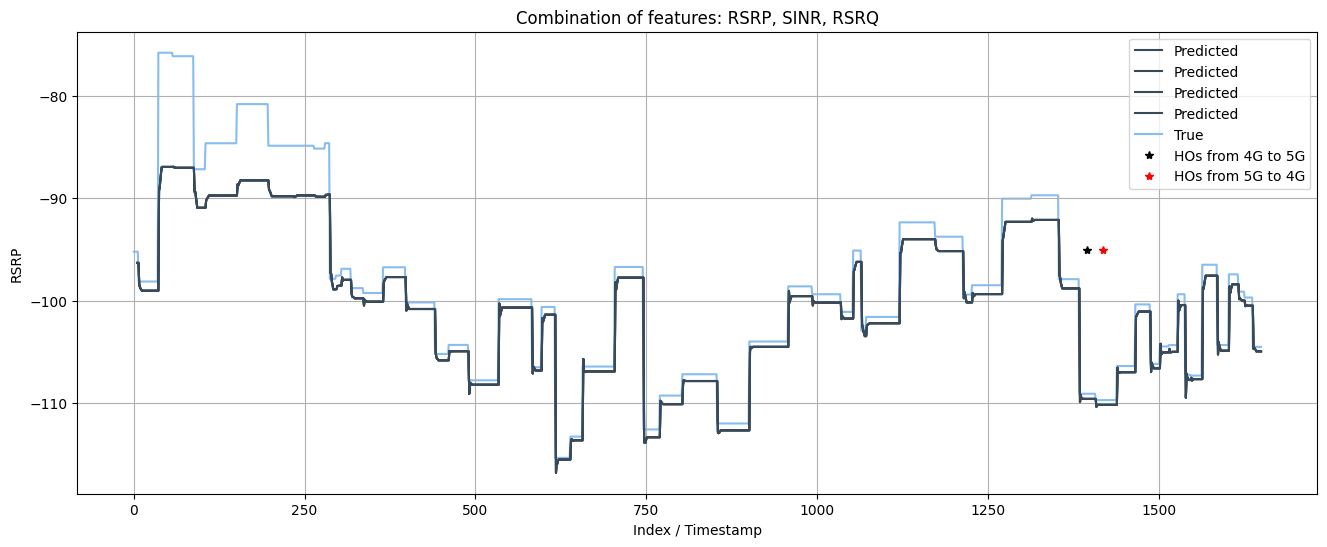

In [27]:
selected_rsrp_comb = 'RSRP, SINR, RSRQ -> RSRP'
rsrp_comb = results[selected_rsrp_comb]
rsrp_pred = rsrp_comb['y_pred']
rsrp_true = rsrp_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
plt.plot(rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.plot(when_5g_ho, [-95 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [-95 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRP')
plt.title(f'Combination of features: RSRP, SINR, RSRQ')
plt.legend()
plt.show()

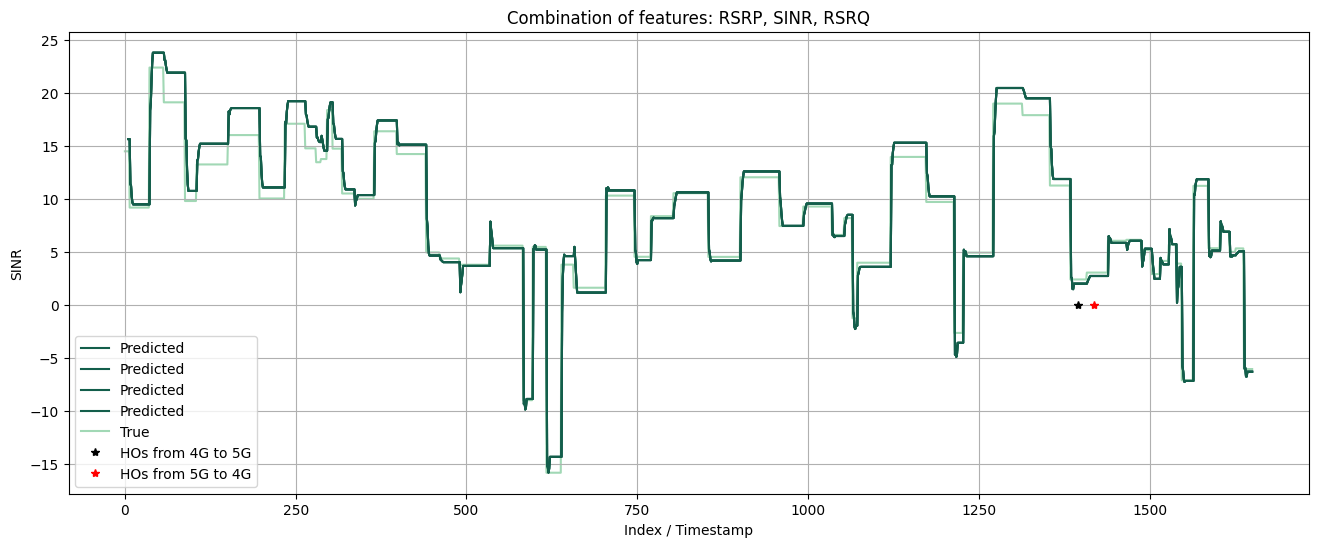

In [28]:
selected_sinr_comb = 'RSRP, SINR, RSRQ -> SINR'
sinr_comb = results[selected_sinr_comb]
sinr_pred = sinr_comb['y_pred']
sinr_true = sinr_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(sinr_pred, label='Predicted', color=sinr_colors[0], zorder=2)
plt.plot(sinr_true, label='True', color=sinr_colors[2], zorder=1)
plt.plot(when_5g_ho, [0 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [0 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('SINR')
plt.title(f'Combination of features: RSRP, SINR, RSRQ')
plt.legend()
plt.show()

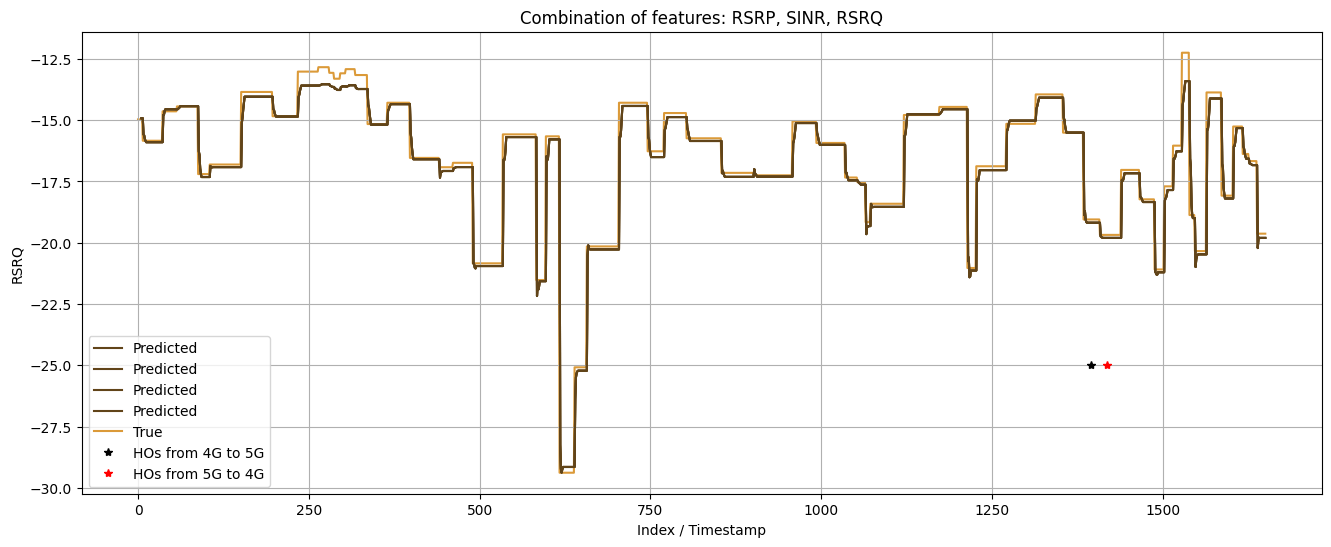

In [29]:
selected_rsrq_comb = 'RSRP, SINR, RSRQ -> RSRQ'
rsrq_comb = results[selected_rsrq_comb]
rsrq_pred = rsrq_comb['y_pred']
rsrq_true = rsrq_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rsrq_pred, label='Predicted', color=rsrq_colors[0], zorder=2)
plt.plot(rsrq_true, label='True', color=rsrq_colors[2], zorder=1)
plt.plot(when_5g_ho, [-25 for _ in range(len(when_5g_ho))], '*', color='black', label='HOs from 4G to 5G')
plt.plot(when_4g_ho, [-25 for _ in range(len(when_4g_ho))], '*', color='red', label='HOs from 5G to 4G')
plt.xlabel('Index / Timestamp')
plt.ylabel('RSRQ')
plt.title(f'Combination of features: RSRP, SINR, RSRQ')
plt.legend()
plt.show()

In [30]:
preds = pd.DataFrame({'RSRP' : [x[0] for x in rsrp_pred],
                      'SINR' : [x[0] for x in sinr_pred],
                      'RSRQ' : [x[0] for x in rsrq_pred]},
                      columns=['RSRP', 'SINR', 'RSRQ'])

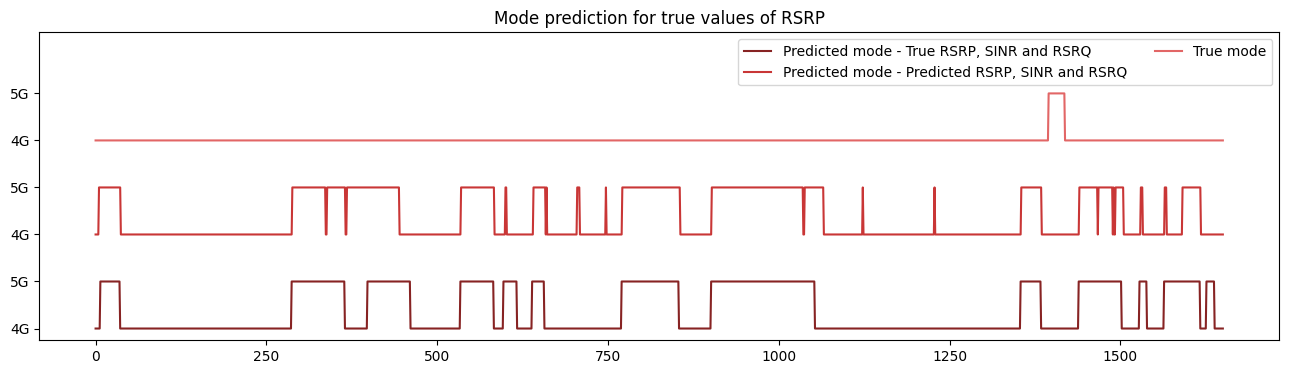

In [35]:
selected_rf_comb = 'RSRP, SINR, RSRQ'
rf_comb = rf_results[selected_rf_comb]
rf_model = rf_comb['model']
rf_pred_true = rf_comb['y_pred']

rf_pred = rf_model.predict(preds)

f = plt.figure(figsize=(16, 4))
plt.plot(rf_pred_true, label='Predicted mode - True RSRP, SINR and RSRQ', color=mode_colors[0])
plt.plot(rf_pred + 2, label='Predicted mode - Predicted RSRP, SINR and RSRQ', color=mode_colors[1])
plt.plot(mode_test['Mode'].values + 4, label='True mode', color=mode_colors[2])
plt.title('Mode prediction for true values of RSRP')
plt.yticks([0, 1, 2, 3, 4, 5], ['4G', '5G', '4G', '5G', '4G', '5G'])
plt.ylim(top=6.3)
plt.legend(ncols=2, loc='upper right')
plt.show()